In [1]:
from tsai.all import *
import sklearn.metrics as skm

from IPython.display import clear_output
computer_setup()

os              : Windows-10-10.0.22621-SP0
python          : 3.8.15
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.9.1+cu111
device          : 1 gpu (['NVIDIA GeForce RTX 2070 SUPER'])
cpu cores       : 8
threads per cpu : 2
RAM             : 31.92 GB
GPU memory      : [8.0] GB


### Resteaze Data

In [2]:
# Read the data
data = pd.read_csv('final_processed.csv', index_col=0)

data.tail()

,level_0,index,unixTimes,accelerometerX,accelerometerY,accelerometerZ,gyroscopeX,gyroscopeY,gyroscopeZ,ledGreen,...,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,bpm_y
9181496,18362992,1310204.5,1.648124e+12,-2192.50,159.75,3402.00,14.25,-199.25,61.50,-38.428602,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9181497,18362994,1310206.5,1.648124e+12,-2194.00,163.75,3395.50,19.75,-201.00,57.75,-29.764807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9181498,18362996,1310208.5,1.648124e+12,-2193.75,167.00,3394.75,17.00,-222.25,58.00,-18.876747,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9181499,18362998,1310210.5,1.648124e+12,-2192.00,161.50,3398.00,22.75,-246.75,54.00,-8.400574,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9181500,18363000,1310212.5,1.648124e+12,-2187.25,163.00,3402.00,25.00,-237.25,58.50,-0.112106,...,225.211012,0.9,0.8,80.0,159.245443,128.474814,64273.934056,1.239507,0.166667,62.5


In [3]:
df = data.copy()

df = df[df.sleep_state != -1]

# Binary Classification
df["sleep_state"] = np.where(df["sleep_state"] == 0, 0, 1)

# fill NaN values
df = df.fillna(method='bfill', limit=1500).dropna()

# # set column time as datetime index
# df['time'] = pd.to_datetime(df['time'])
# df = df.set_index('time', drop=True)

df = df[['ledGreen', 'bpm_y', 'sleep_state']]

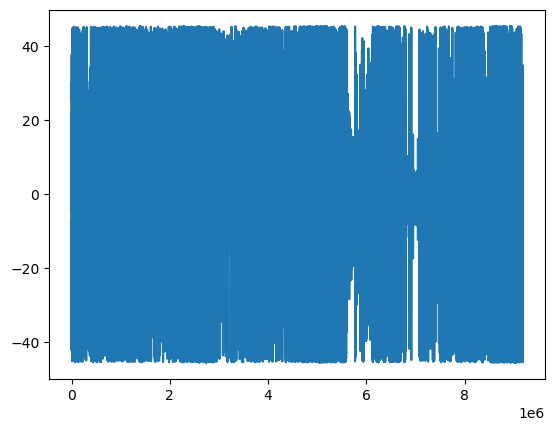

In [4]:
# remove extreme values from the signal (outliers)

def remove_extreme_values(signal, threshold):
    # Compute the absolute difference between the signal and its mean
    absolute_difference = np.abs(signal - np.mean(signal))
    # Compute the median of the absolute difference
    median_absolute_difference = np.median(absolute_difference)
    # Compute the median absolute deviation
    median_absolute_deviation = 1.4826 * median_absolute_difference
    # Compute the z-score
    z_score = 0.6745 * (absolute_difference / median_absolute_deviation)
    # Remove the extreme values
    signal = signal[z_score < threshold]
    return signal


# Example usage
filtered_ppg = remove_extreme_values(df['ledGreen'], threshold=3.0)
filtered_bpm = remove_extreme_values(df['bpm_y'], threshold=3.0)

df['ledGreen'] = filtered_ppg
df['bpm_y'] = filtered_bpm

df = df.dropna()

plt.plot(filtered_ppg)

In [5]:
# Non null values in the dataset
df.isnull().sum()

ledGreen       0
bpm_y          0
sleep_state    0
dtype: int64

In [6]:
class_map = {
    0: 'WK',  # wake
    1: 'SL',  # sleep
}
class_map

{0: 'WK', 1: 'SL'}

<AxesSubplot:>

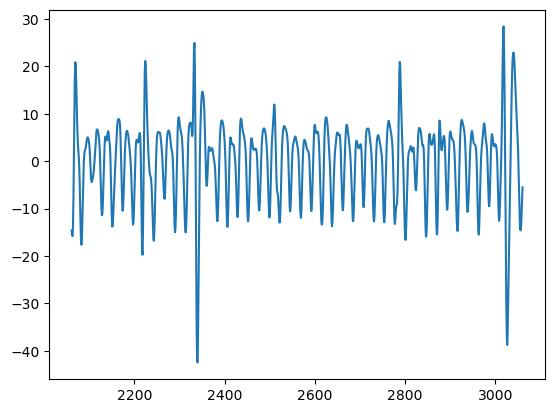

In [7]:
df['ledGreen'][2000:3000].plot()

In [8]:
import plotly.graph_objs as go
import numpy as np
from plotly_resampler.figure_resampler import FigureWidgetResampler
from plotly.subplots import make_subplots

n = len(df)  # the nbr of data points
x = np.arange(n)

# Wrap a figure with FigureWidgetResampler
fw_fig = FigureWidgetResampler(make_subplots(rows=1, shared_xaxes=False))

fw_fig.add_trace(go.Scattergl(), hf_x=x, hf_y=df['ledGreen'], row=1, col=1)
fw_fig.add_trace(go.Scattergl(),
                 hf_x=x,
                 hf_y=df['bpm_y'],
                 row=1,
                 col=1)

fw_fig.update_layout(height=800, showlegend=True)

# Output this wrapped instance in a cell
fw_fig


FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> trace 0 <i style="color:#fc…

In [28]:
df

,ledGreen,bpm_y,sleep_state
0,25.681676,70.16129,0
25,29.471284,70.16129,0
47,20.254009,70.16129,0
48,-7.132885,70.16129,0
49,-32.366288,70.16129,0
...,...,...,...
9181496,-38.428602,62.50000,1
9181497,-29.764807,62.50000,1
9181498,-18.876747,62.50000,1
9181499,-8.400574,62.50000,1


# Filters and transforms

## TSData preparation


## Data from 3d array

In [229]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder


scaler = StandardScaler()
le = LabelEncoder()

temp_df = df[['ledGreen', 'bpm_y', 'sleep_state']]
X = scaler.fit_transform(temp_df[['ledGreen', 'bpm_y']])
y = le.fit_transform(temp_df['sleep_state'])

# selecting sequences range
X = X[0:(len(X) - len(X)%1500)]
y = y[0:(len(y) - len(y)%1500)]

# reshape the data to tsai format
X = X.reshape(-1, 1500, 2)
X = X.transpose(0, 2, 1)
y = y.reshape(-1, 1500)
y = (y.sum(axis=1) // 1500).reshape(-1, 1).flatten()

print(X.shape, y.shape)

pd.DataFrame(X[0])

(4274, 2, 1500) (4274,)


,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,2.024760,2.326848,1.592093,-0.591053,-2.602533,-3.363483,-2.667603,-1.991783,-1.392072,-0.917942,...,-0.235441,-0.435646,-0.593681,-0.684822,-0.699172,-0.643736,-0.535140,-0.385788,-0.208664,-0.035308
1,-0.348053,-0.348053,-0.348053,-0.348053,-0.348053,-0.348053,-0.348053,-0.348053,-0.348053,-0.348053,...,0.114407,0.114407,0.114407,0.114407,0.114407,0.114407,0.114407,0.114407,0.114407,0.114407


In [230]:
# sht = len(X) // 1500
# print("Samples: ", sht)

# X = X.T.reshape(sht, 2, 1500)
# y = (y.T.reshape(sht, 1500).sum(axis=1) // 1500).reshape(-1, 1).flatten()

# X.shape, y.shape

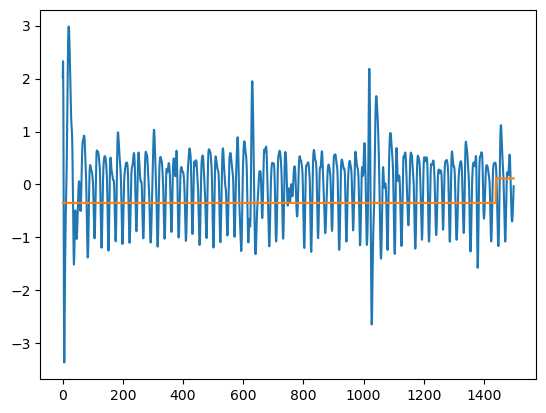

In [231]:
# plot the first 2 sequences
plt.plot(X[0].T)

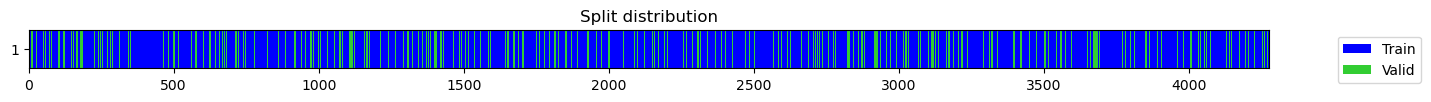

((#3420) [1811,1139,2601,2856,4098,180,634,2286,2369,820...],
 (#854) [1027,1229,1435,1597,2640,559,3684,289,550,644...])

In [232]:
splits = get_splits(y,
                    valid_size=.2,
                    stratify=True,
                    random_state=1223,
                    shuffle=True)
splits

In [233]:
labeler = ReLabeler(class_map)
new_y = labeler(y) # map to more descriptive labels

X.shape, new_y.shape, splits, new_y

((4274, 2, 1500),
 (4274,),
 ((#3420) [1811,1139,2601,2856,4098,180,634,2286,2369,820...],
  (#854) [1027,1229,1435,1597,2640,559,3684,289,550,644...]),
 array(['WK', 'WK', 'WK', ..., 'SL', 'SL', 'SL'], dtype='<U2'))

In [234]:
label_counts = collections.Counter(new_y)
print('Counts by label:', dict(label_counts))
print(f'Naive Accuracy: {100*max(label_counts.values())/sum(label_counts.values()):0.2f}%')

Counts by label: {'WK': 1412, 'SL': 2862}
Naive Accuracy: 66.96%


In [235]:
tfms = [None, [TSClassification()]]  # TSClassification == Categorize
batch_tfms = TSStandardize()

## Dataloaders

In [236]:
dls = get_ts_dls(X, new_y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128])
dls.dataset

(#3420) [(TSTensor(vars:2, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:2, len:1500, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:2, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:2, len:1500, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:2, len:1500, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:2, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:2, len:1500, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:2, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:2, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:2, len:1500, device=cpu, dtype=torch.float32), TensorCategory(0))] ...]

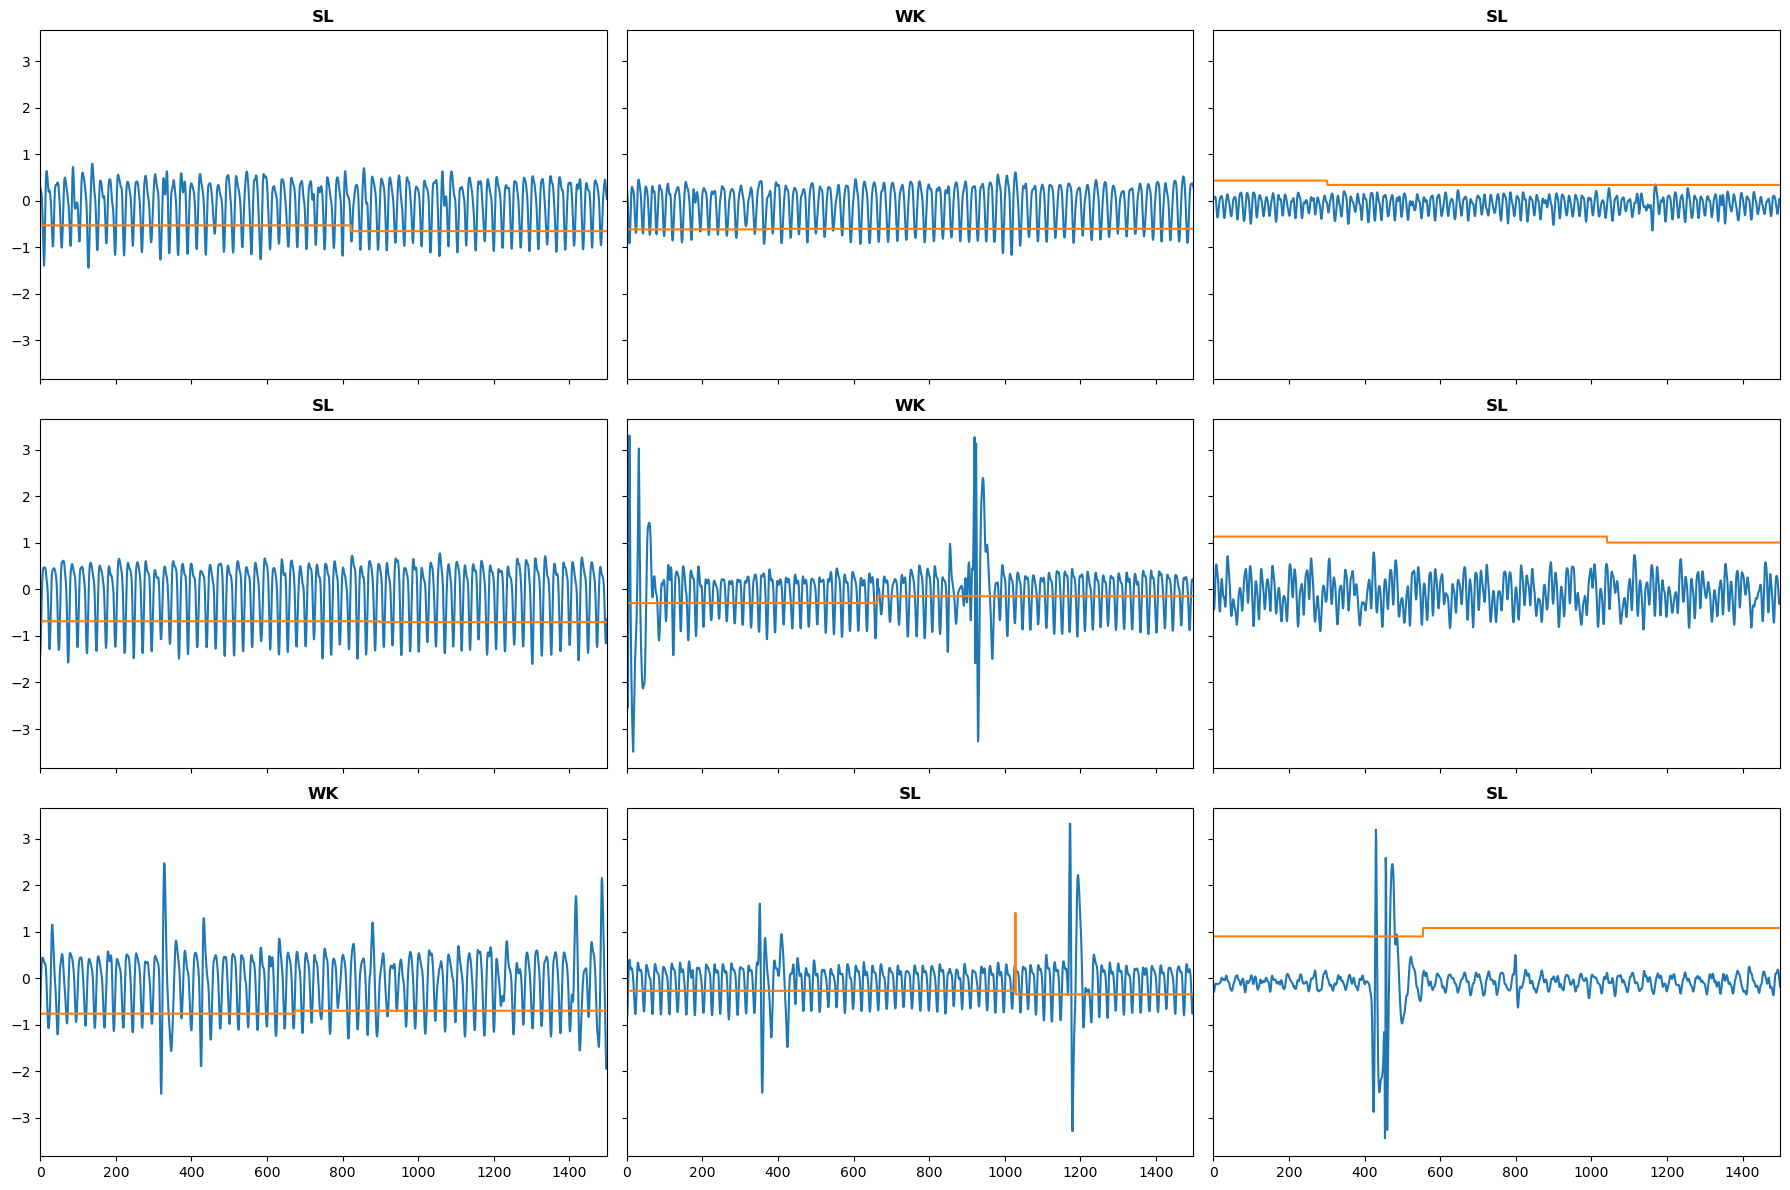

In [237]:
dls.show_batch(sharey=True)

## Build learner

In [179]:
archs = [(InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}), (mWDN, {'levels': 4}),
         (FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}),
         (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}),
         (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
         (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False})]


# for i, (arch, k) in enumerate(archs):
#     print(f'arch: {arch.__name__}')

results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
for i, (arch, k) in enumerate(archs):
    model = build_ts_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = ts_learner(dls, model,  metrics=[accuracy, Precision(), Recall(), F1Score()])
    start = time.time()
    learn.fit_one_cycle(10, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    clear_output()
    display(results)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,InceptionTime,{},455298,0.334042,0.350729,0.853630,109
1,ResNet,{},478978,0.366262,0.360229,0.850117,44
2,xresnet1d34,{},7228354,0.359401,0.362774,0.833724,50
3,OmniScaleCNN,{},968257,0.390315,0.424114,0.832553,3179
4,ResCNN,{},256771,0.399954,0.397554,0.830211,31
5,LSTM_FCN,{},906218,0.379979,0.431064,0.819672,23
6,LSTM_FCN,{'shuffle': False},307018,0.432293,0.431775,0.810304,92
7,XceptionTime,{},399380,0.476233,0.474569,0.804450,64
8,FCN,{},265218,0.446375,0.441078,0.800937,21
9,LSTM,"{'n_layers': 3, 'bidirectional': False}",203402,0.552827,0.562336,0.738876,232


In [185]:
metrics = [accuracy, Precision(), Recall(), F1Score()]

# chose the best model from results table
model = build_ts_model(InceptionTime, dls=dls)

learn = ts_learner(dls, model, metrics=metrics, cbs=ShowGraph())

In [186]:
# learn = Learner(dls, model, metrics=accuracy)

## LR find

SuggestedLRs(valley=0.0005754399462603033)

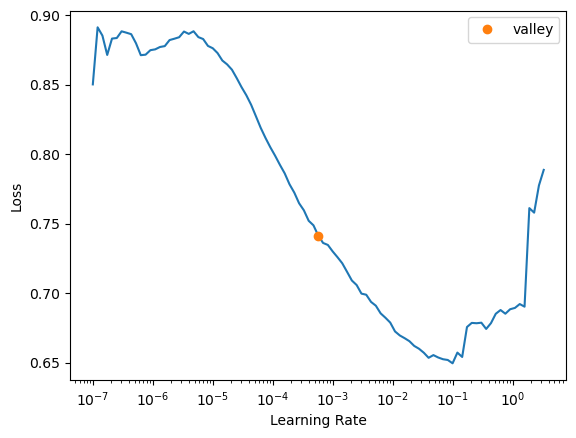

In [187]:
# learn.load('stage0')
learn.lr_find()

## Learner feature importance

X.shape: (3420, 2, 1500)
y.shape: (3420,)
Selected metric: accuracy
Computing feature importance (permutation method)...


  0 feature: BASELINE             accuracy: 0.473684


  0 feature: var_0                accuracy: 0.492398


  1 feature: var_1                accuracy: 0.455848



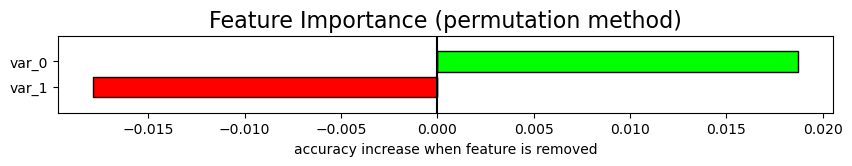

,Feature,accuracy,accuracy_change
0,var_0,0.492398,0.018713
1,BASELINE,0.473684,0.000000
2,var_1,0.455848,-0.017836


In [188]:
learn.feature_importance()

In [189]:
# learn.step_importance()

Before temperature - NLL: 0.728, ECE: 0.067
Calibrating the model...
...model calibrated
Optimal temperature: 468.406
After temperature  - NLL: 0.693, ECE: 0.002



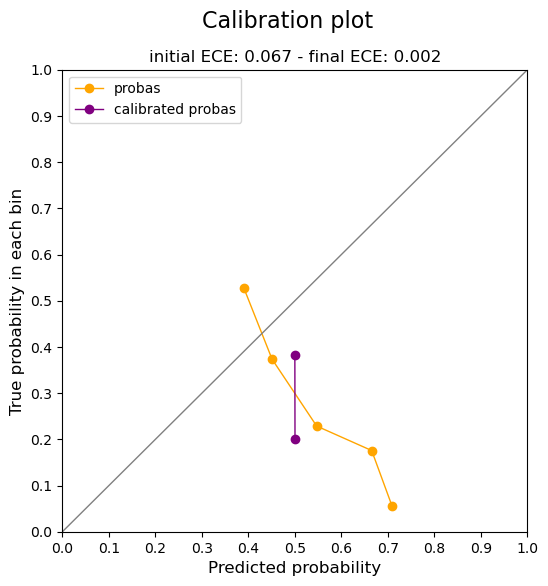

In [190]:
learn.calibrate_model()

# Fit model

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.566035,0.526599,0.769321,0.805755,0.397163,0.532067,00:11
1,0.500572,0.499172,0.784543,0.676259,0.666667,0.671429,00:10
2,0.474525,0.572299,0.728337,0.562814,0.794326,0.658824,00:10
3,0.464244,0.454984,0.805621,0.707143,0.702128,0.704626,00:11
4,0.456897,0.467970,0.812646,0.731061,0.684397,0.706960,00:10
5,0.446280,0.495706,0.785714,0.792899,0.475177,0.594235,00:11
6,0.442976,0.535123,0.740047,0.928571,0.230496,0.369318,00:11
7,0.435734,0.411103,0.822014,0.764228,0.666667,0.712121,00:10
8,0.404870,0.467632,0.776347,0.638298,0.744681,0.687398,00:10
9,0.398513,0.392534,0.830211,0.887006,0.556738,0.684096,00:10


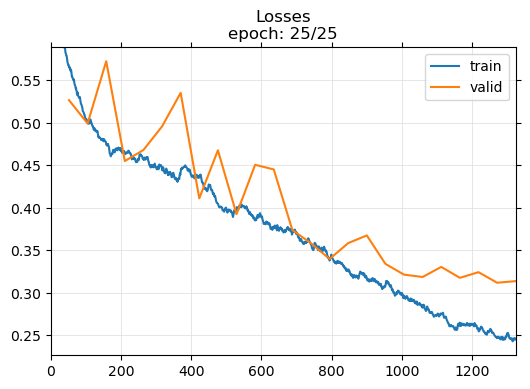

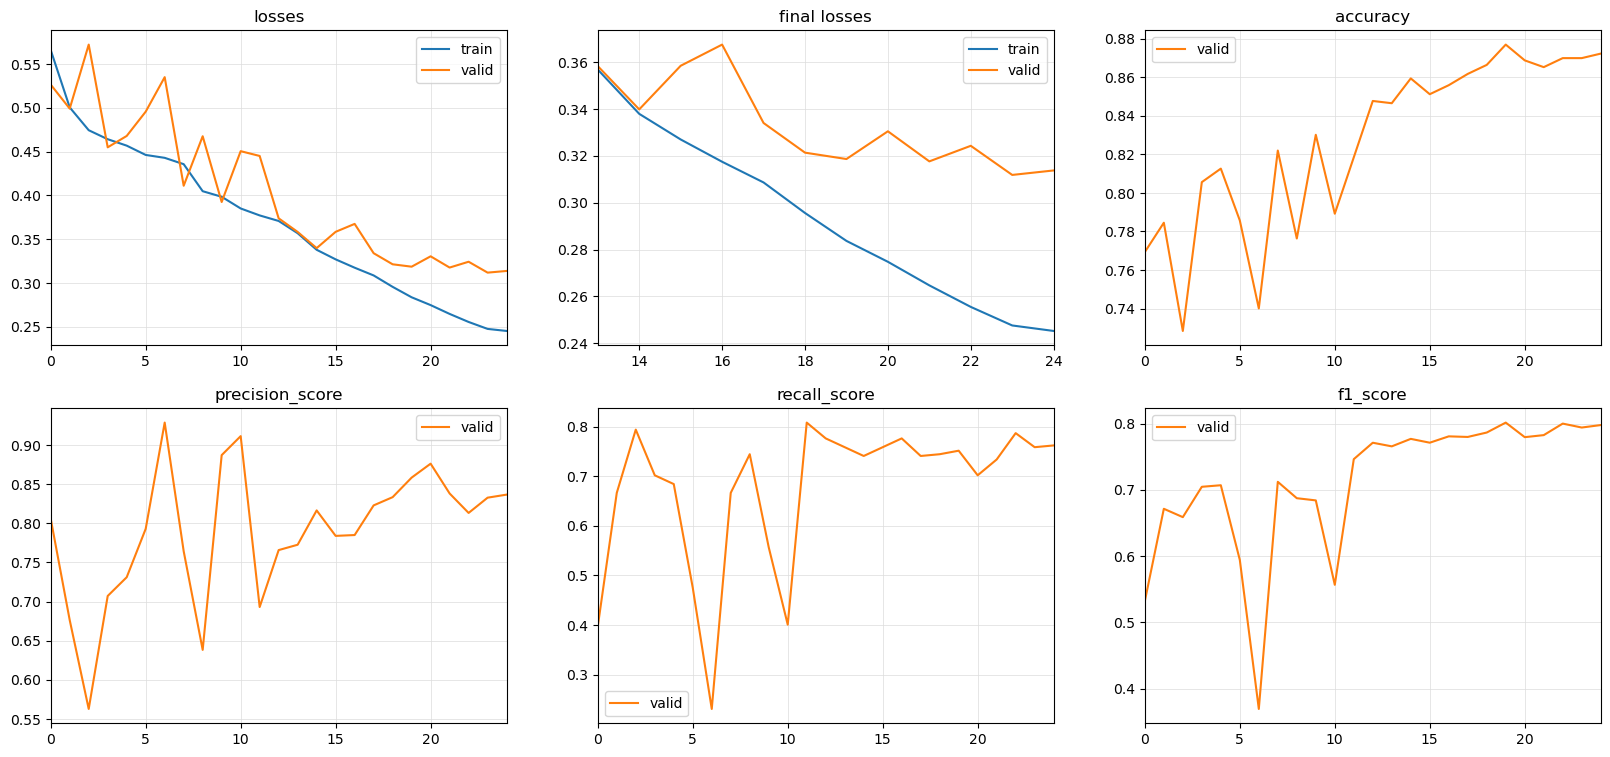

In [191]:
learn.fit_one_cycle(25, lr_max=1e-3)

In [ ]:
# learn.fit_flat_cos(10, 0.025)

In [ ]:
learn.plot_metrics()

## Transformers 

In [ ]:
# model = TST(dls.vars, dls.c, dls.len, dropout=.3)
# learn = Learner(dls,
#                 model,
#                 loss_func=LabelSmoothingCrossEntropyFlat(),
#                 metrics=[RocAucBinary(), accuracy],
#                 cbs=ShowGraphCallback2())
# start = time.time()
# learn.fit_one_cycle(25, lr_max=1e-4)
# print('\nElapsed time:', time.time() - start)
# learn.plot_metrics()
# beep()

##### Save model

In [192]:
learn.save('ppg_bpm')

Path('models/ppg_bpm.pth')

In [193]:
learn.save_all(path='export_bpm_ppg',
               dls_fname='dls',
               model_fname='model',
               learner_fname='learner')

## Inferece


In [194]:
# learn = load_learner_all(path='export_rmmsd',
#                          dls_fname='dls',
#                          model_fname='model',
#                          learner_fname='learner')

dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

(TSTensor(samples:128, vars:2, len:1500, device=cuda:0, dtype=torch.float32),
 TensorCategory([0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
         1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
         0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
         1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0'))

In [195]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl,
                                                           with_decoded=True)
valid_probas, valid_targets, valid_preds

(tensor([[0.7336, 0.2664],
         [0.0314, 0.9686],
         [0.0081, 0.9919],
         ...,
         [0.9591, 0.0409],
         [0.9890, 0.0110],
         [0.8729, 0.1271]]),
 tensor([0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
         1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
         0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
         1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
         1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
         1, 

In [196]:
(valid_targets == valid_preds).float().mean()

tensor(0.8724)

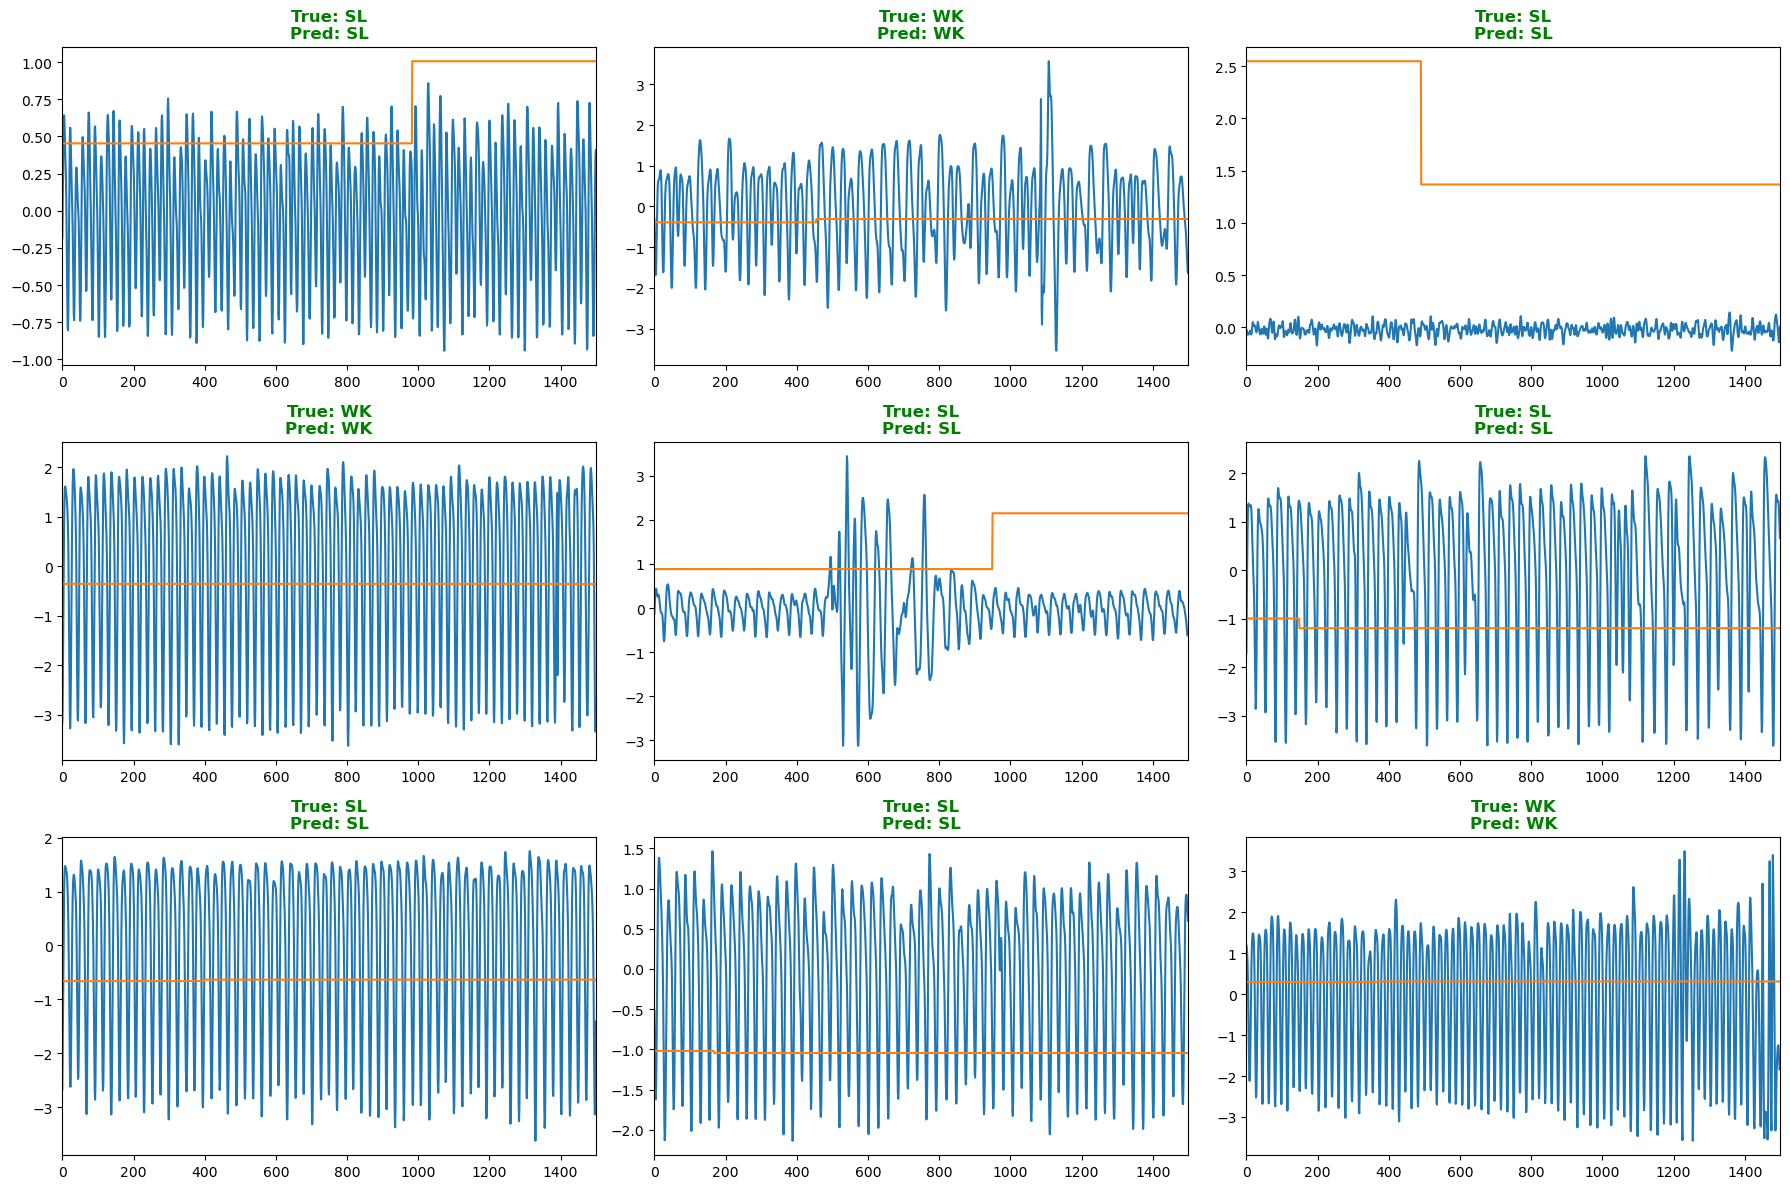

In [225]:
learn.show_results()


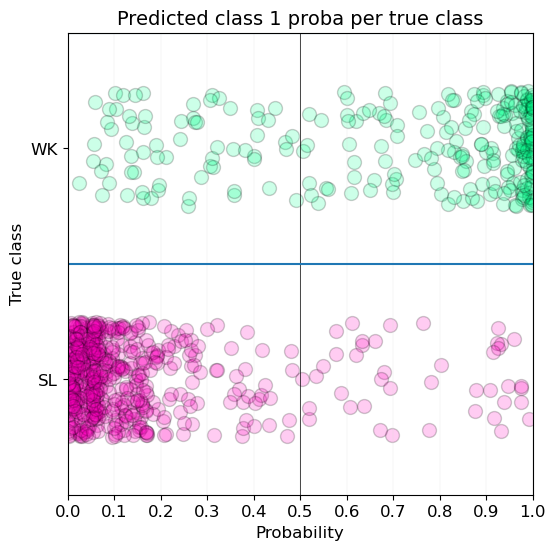

In [198]:
learn.show_probas()


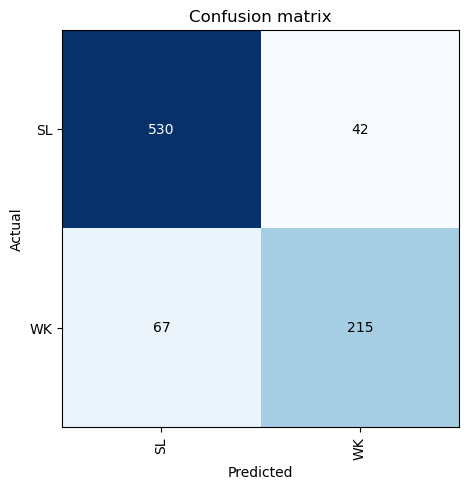

In [199]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [200]:
interp.most_confused(min_val=3)

[('WK', 'SL', 67), ('SL', 'WK', 42)]

In [201]:
print(f'accuracy: {skm.accuracy_score(valid_targets, valid_preds):10.6f}')

accuracy:   0.872365


# inference on unseen data

In [372]:
# Read the data
test_data = pd.read_csv('final_test_processed.csv', index_col=0)

test_data = test_data[test_data.sleep_state != -1]

# Binary Classification
test_data["sleep_state"] = np.where(test_data["sleep_state"] == 0, 0, 1)

# fill NaN values
test_data = test_data.fillna(method='bfill', limit=1500).dropna()

test_data = test_data[['ledGreen', 'bpm', 'sleep_state']]


##  remove extreme values from the signal (outliers)

def remove_extreme_values(signal, threshold):
    # Compute the absolute difference between the signal and its mean
    absolute_difference = np.abs(signal - np.mean(signal))
    # Compute the median of the absolute difference
    median_absolute_difference = np.median(absolute_difference)
    # Compute the median absolute deviation
    median_absolute_deviation = 1.4826 * median_absolute_difference
    # Compute the z-score
    z_score = 0.6745 * (absolute_difference / median_absolute_deviation)
    # Remove the extreme values
    signal = signal[z_score < threshold]
    return signal


# Example usage
filtered_ppg = remove_extreme_values(test_data['ledGreen'], threshold=3.0)
filtered_bpm = remove_extreme_values(test_data['bpm'], threshold=3.0)

test_data['ledGreen'] = filtered_ppg
test_data['bpm'] = filtered_bpm

test_data = test_data.dropna().reset_index(drop=True)
test_data

,ledGreen,bpm,sleep_state
0,41.774037,69.942611,0
1,-5.221806,69.942611,0
2,-48.338492,69.942611,0
3,-56.224560,69.942611,0
4,-40.920576,69.942611,0
...,...,...,...
800163,-11.443656,79.062958,1
800164,-13.532598,79.062958,1
800165,-13.153214,79.062958,1
800166,-10.268526,79.062958,1


In [365]:
scaler = StandardScaler()
le = LabelEncoder()

X_test = scaler.fit_transform(test_data[['ledGreen', 'bpm',]])
y_test = le.fit_transform(test_data['sleep_state'])

# selecting sequences range
X_test = X_test[0:(len(X_test) - len(X_test)%1500)]
y_test = y_test[0:(len(y_test) - len(y_test)%1500)]

In [366]:
# reshape the data to tsai format
X_test = X_test.reshape(-1, 1500, 2)
X_test = X_test.transpose(0, 2, 1)
y_test = y_test.reshape(-1, 1500)
y_test = (y_test.sum(axis=1) // 1500).reshape(-1, 1).flatten()

print(X_test.shape, y_test.shape)

pd.DataFrame(X_test[0]).head()

(533, 2, 1500) (533,)


,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,2.055550,-0.446943,-2.742874,-3.162801,-2.347876,-1.622044,-0.989131,-0.431572,0.074580,0.553212,...,-0.727971,-0.926758,-1.017102,-0.993538,-0.877565,-0.699500,-0.485367,-0.260971,-0.058985,0.089138
1,-0.040561,-0.040561,-0.040561,-0.040561,-0.040561,-0.040561,-0.040561,-0.040561,-0.040561,-0.040561,...,-0.056903,-0.056903,-0.056903,-0.056903,-0.056903,-0.056903,-0.056903,-0.056903,-0.056903,-0.056903


In [368]:
# # plot the first 10 sequences
# for i in range(10):
#     plt.plot(X_test[i][0])
#     plt.plot(X_test[i][1])
#     plt.show()

In [369]:
# Labelled test data
test_ds = valid_dl.dataset.add_test(X_test)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))


(TSTensor(samples:128, vars:2, len:1500, device=cuda:0, dtype=torch.float32),)

In [370]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl,
                                                        with_decoded=True,
                                                        save_preds=None,
                                                        save_targs=None)
test_probas, test_targets, test_preds


(tensor([[0.7831, 0.2169],
         [0.7730, 0.2270],
         [0.7855, 0.2145],
         ...,
         [0.9909, 0.0091],
         [0.9856, 0.0144],
         [0.9715, 0.0285]]),
 None,
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
         0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
     

In [371]:
print(f'accuracy: {skm.accuracy_score(y_test, test_preds):10.6f}')

accuracy:   0.326454


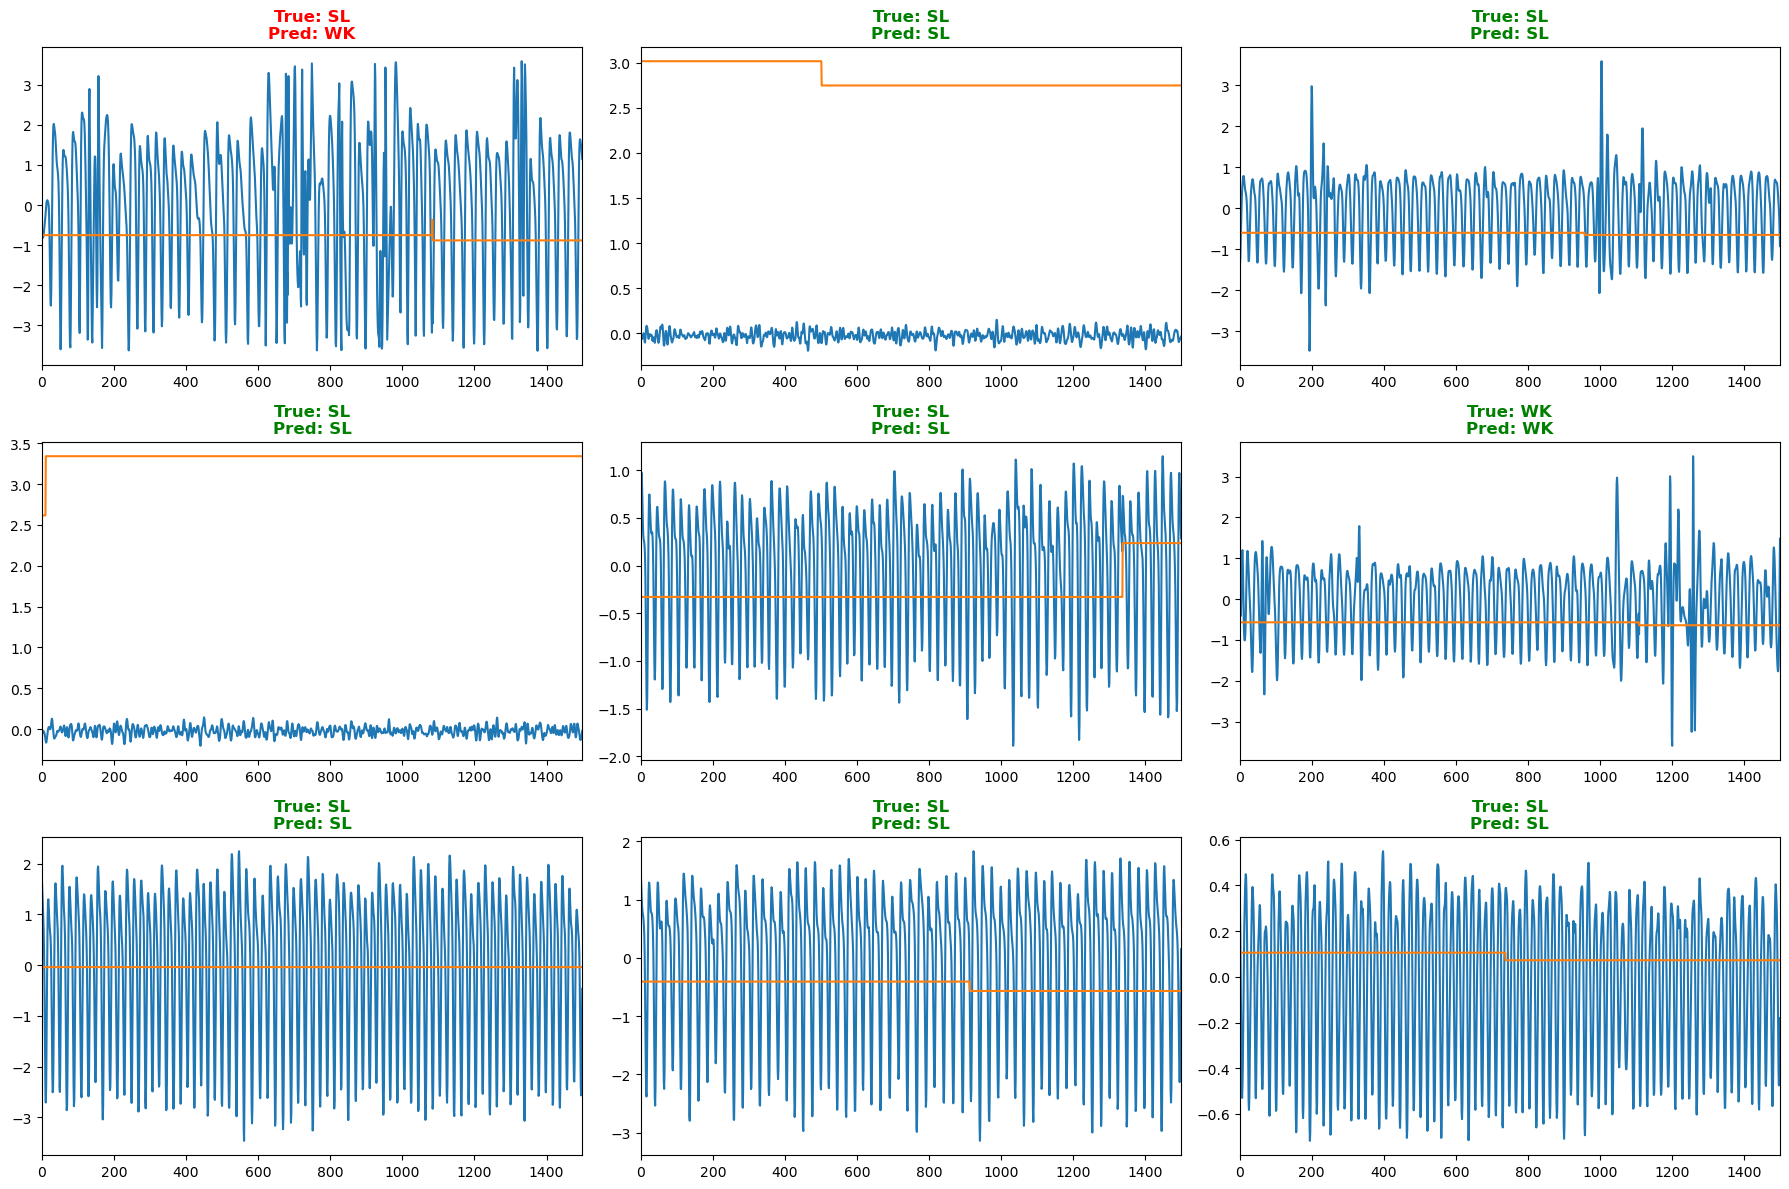

In [357]:
learn.show_results()


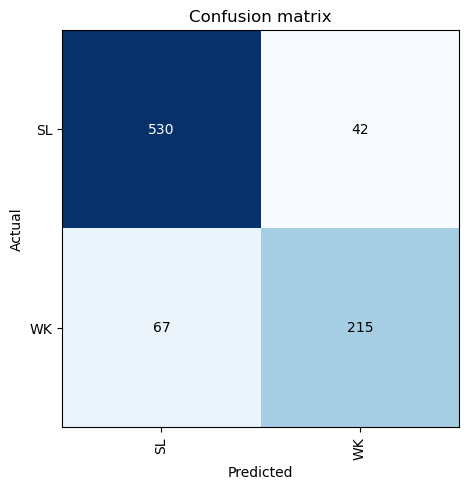

In [358]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### If unlabelled data

In [359]:
# Unlabelled data
test_ds = dls.dataset.add_test(X_test)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:128, vars:2, len:1500, device=cuda:0, dtype=torch.float32),)

In [360]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas


tensor([[0.0448, 0.9552],
        [0.0296, 0.9704],
        [0.0170, 0.9830],
        ...,
        [0.2382, 0.7618],
        [0.0806, 0.9194],
        [0.0223, 0.9777]])